# Notebook Profiles

This exploratory coding notebook explores several techniques to support the static profiling of Jupyter notebooks as texts, reporting on various metrics, including:

- notebook size (markdown and code line counts);
- readability scores;
- reading time estimates;
- code complexity and maintability.

The motivating context was a tool for generating summary reports on the estimated workload associated with 100 or so  notebooks over 25 or so directories (1 directory / 4 notebooks per week) for a third year undergraduate equivalent Open University course on data management and analysis.

Previous notebook recipes include generating simple reports that pull out headings from notebooks to act as notebook summaries (eg [`Get Contents`](https://github.com/innovationOUtside/TM351_forum_examples/blob/master/Get%20Contents.ipynb)). Such recipes may provide a useful component in a notebook quality report if the report is also intended to provide a summary / overview of notebooks. (It might be most useful to offer heading summaries as an option in a notebook profiling report?)

Tools supporting the profiling of one or more notebooks across one or more directories and the generation of simple statistics over them are also provided.

The profiler is also capabale of running simple health checks over a notebook, for example reporting on:

- whether code cells have been executed, and if so, whether code cell execution in complete and in linear order;
- packages / modules loaded in to the notebook;
- unused code items in a notebook (for example, modules loaded but not used).

Currently, code profiling is only applied to code that appears in code cells, not code that is quoted or described in markdown cells.

There is a potential for making IPython magics for some of the reporting functions (for example, `radon` or `wily` reports) to provide live feedback / reporting during the creation of content in a notebook.

*Code has been extract from this notebook into the `nb_quality_profile` package. If experiments are made updating code in this notebook, it will need mirroring in the actual package...*

### Notebooks

In the first instance, reports are generated for code cell inputs and markdown cells; code outputs and raw cells are not considered. Code appearing in markdown cells is identified as code-like but not analysed in terms of code complexity etc.

For each markdown cell, we can generate a wide range of simple text document statistics. Several packages exist to support such analyses (for example, [`textstat`](https://github.com/shivam5992/textstat), [`readability`](https://github.com/andreasvc/readability/)) but the focus in this notebook will be on metrics derived using the [`spacy`](https://spacy.io/) underpinned by the local `text_stats.py` package for things like readability metrics. Several simple custom metrics are also suggested.

For code in code cells, the [`radon`](https://radon.readthedocs.io) package is used to generate code metrics, with additional packages providing further simple metrics.

A test notebook is provided (`Notebook_profile_test.ipynb`) against which we can test various elements of this notebook.

### Potential Future Work

In terms of analysing cell outputs (not covered as yet), reports could be generated on the sorts of asset that appear to be displayed in each cell output, whether code warnings or errors are raised, etc. There is also potential for running in association with something like [`nbval`](https://github.com/computationalmodelling/nbval) to test that notebooks test correctly against previously run cell outputs.

We might also explore the extent to which interactive notebook profiling tools, such as magics or notebook extensions, be used to support the authoring of new instructional notebooks.

We might also ask to what extent might interactive notebook profiling tools be used to support learners working through instructional material and reflecting on their work? Code health metrics, such as [cell execution success](https://nbgallery.github.io/health_paper.html) used by *nbgallery* may provide clues regarding which code activity cells students struggled to get working, for example. By looking at statistics across students (for example, in assessment notebooks with cell execution success log monitoring enabled) we may be able to identify "healthy" or "unhealthy" activities; for example, a healthy activity is one in which students can get their code to run with one or two tries, an unhealthy activity is one where they make repeated attempts at trying to get the code to work as they desire.

The notebook profiler should also be runnable against notebooks created using Jupytext from markdown rendered from OU-XML. It would probably make *more* sense to build a custom OU-XML profiler, eg one that could perhaps draw on a summary XML doc generated from OU-XML source docs using XSLT. I'll try to bear in mind creating reporting functions that might be useable in this wider sense. (OU-XML will also have thngs like a/v components, and may have explicit time guidance on expected time spent on particular activities.)


In [1]:
# Last using numpy 1.x
#%pip install --upgrade numpy<2 spacy==3.7.5 pandas==2.2.2 scikit-learn==1.4.0

## Settings

The following parameters are used notebook wide in the generation of reports.

In [1]:
READING_RATE = 100 # words per minute
# What is a sensible reading rate for undergraduate level academic teaching material?
# 250 wpm gives a rate of 15,000 wph
# 10,000 wph corresponds to about 170 words per minute
# OU guidance: 35 wpm for challenging texts, 70 wpm for medium texts, 120 wpm for easy texts

CODE_READING_RATE = 35 # tokens per minute -- UNUSED

CODE_LINE_READING_TIME = 1 # time in seconds to read a code line

LINE_WIDTH = 160 #character width of a line of markdown text; used to calculate "screen lines"

CODE_CELL_REVIEW_TIME = 5 # nominal time in seconds to run each code cell / review each code cell output

CELL_SKIP_TIME = 1 # nominal time in seconds to move from one cell to the next

## Open Notebook

Open and read a notebook, such as the associated test notebook:

In [2]:
import nbformat

In [3]:
TEST_NOTEBOOK = '../Notebook_profile_test.ipynb'
with open(TEST_NOTEBOOK,'r') as f:
    nb = nbformat.reads(f.read(), as_version=4)

## Analyse Markdown Cells

Iterate through markdown cells and generate cell by cell reports.

We can start off by generating some simple counts for a single notebook.

Let's preview the contents of a single cell:

In [4]:
nb.cells[0]

{'cell_type': 'markdown',
 'metadata': {},
 'source': '# Test Notebook for Notebook Profiler\n\nThis notebook provides a test case for the notebook profiler.\n\nIt includes a range of markdown and code cells intended to test various features of the profiler.\n\nNote that this notebook does not necessarily run...'}

We can look at just the markdown component associated with a markdown cell - this will be the basis for our markdown text analysis.

In [5]:
txt = nb.cells[0]['source']

Estimates of reading time are often based on word count estimates. The Medium website use a reading time estimator that also factors in the presence of images in a text as well as wordcount / sentence length. The [`readtime`](https://github.com/alanhamlett/readtime) package uses the Medium reading time estimation algorithm to give a reading time estimate.


?? TO DO - more on the reading time equation; also need something like maybe: +10s for every code cell to run it and look at output? Different reading time per line of code?

*It might be worth looking at forking this reading time estimator and try to factor in reading time elements that reflect the presence of code? Or maybe use a slower reading rate for code? Or factor in code complexity? The presence of links might also affect reading time.*

In [6]:
# https://github.com/alanhamlett/readtime
#%pip install readtime

import readtime
import math

In [7]:
rt = readtime.of_markdown(txt, wpm=READING_RATE).delta.total_seconds()

#Round up on the conversion of estimated reading time in seonds, to minutes...
f'Reading time in seconds: {rt}; in minutes: {math.ceil(rt/60)}.'

'Reading time in seconds: 25.0; in minutes: 1.'

The `spacy` natural language processing package provides a wide ranging of basic tools for parsing texts.

In [8]:
#%pip install --upgrade spacy pandas scikit-lean

In [9]:
#%pip install spacy
import spacy

# Check we have the small English model at least
SPACY_LANG_MODEL = 'en_core_web_sm'

try:
    import en_core_web_sm
except:
    import spacy.cli
    spacy.cli.download(SPACY_LANG_MODEL)

# Load a model that a text is parsed against
nlp = spacy.load(SPACY_LANG_MODEL)

To call on `spacy`, we need to create tokenised document representation of the text (conveniently, the original text version is also stored as part of the object).

In [10]:
doc = nlp(txt)

One way of using readability measures would be to set reading rates dynamically for each markdown cell based on calculated readability scores.

In [12]:
from .text_stats import text_stats_summary

The following statistics are providied by `text_stats_summary`.

Basic counts:

- `n_chars`
- `n_chars_per_word`
- `n_long_words`
- `n_monosyllable_words`
- `n_polysyllable_words`
- `n_sents`
- `n_syllables`
- `n_syllables_per_word`
- `n_unique_words`
- `n_words`
- `sentence_lengths`
- `sentence_length_mean`
- `sentence_length_median`
- `sentence_length_stdev`



Readability:

- `automated_readability_index`
- `coleman_liau_index`
- `flesch_kincaid_grade_level`
- `flesch_reading_ease`
- `gunning_fog_index`
- `smog_index`

In [13]:
counts, readability = text_stats_summary(doc)
counts, readability

({'n_chars': 252,
  'n_words': 40,
  'n_sents': 3,
  'n_unique_words': 27,
  'n_syllables': 73,
  'n_monosyllable_words': 21,
  'n_polysyllable_words': 13,
  'n_long_words': 15,
  'sentence_length_mean': 14.666666666666666,
  'sentence_length_median': 18,
  'sentence_length_stdev': 5.773502691896257,
  'sentence_legths': [18, 18, 8]},
 {'flesch_reading_ease': 38.906666666666695,
  'flesch_kincaid_grade_level': 11.145,
  'automated_readability_index': 14.909666666666666,
  'coleman_liau_index': 19.023999999999997,
  'smog_index': None,
  'gunning_fog_index': 18.333333333333336})

Also pull out notable features in a text, such as acronyms and key terms, which may be useful as part of a notebook summary.

In [15]:
# Extract acronyms and keyterms
from .text_stats import extract_acronyms, extract_keyterms

In [16]:
extract_acronyms(doc)

{}

In [17]:
try:
    extract_keyterms(doc)
except Exception as e:
    #raise(e)
    display(e)

ValueError('Iterable over raw text documents expected, string object received.')

As well as using measures provided by off-the-shelf packages, it's also useful to define some simple metrics of our own that don't appear in other packages.

To start with, let's try to estimate the notebook length as it appears on screen by calculating how many "screen lines" a markdown cell is likely to take up. This can be calculated by splitting long lines of text over multiple lines based on a screen line width parameter.

In [18]:
import textwrap

def _count_screen_lines(txt, width=LINE_WIDTH):
    """Count the number of screen lines that a markdown cell takes up."""
    ll = txt.split('\n\n')
    _ll = []
    for l in ll:
        #Model screen flow: split a line if it is more than `width` characters long
        _ll=_ll+textwrap.wrap(l, width)
    n_screen_lines = len(_ll)
    return n_screen_lines

In [19]:
screen_txt='As well as "text", markdown cells may contain cell blocks. The following is a basic report generator for summarising key statistical properties of code blocks. (We will see later an alternative way of calculating such metrics for well form Python code at least.)'
_count_screen_lines(screen_txt)

2

As well as "text", markdown cells may contain cell blocks. The following is a basic report generator for summarising key statistical propererties of code blocks. (We will see later an alternative way of calculating such metrics for well form Python code at least.)

In [20]:
def _code_block_summarise(lines,
                          n_blank_code_lines = 0,
                          n_single_line_comment_code_lines = 0,
                          n_code_lines = 0):
    
    lines = lines.splitlines() if isinstance(lines, str) else lines
    
    #if lines[0].startwsith('%%'): 
        ##block magic - we could detect which?
        #This would let us report on standard block magic such as %%bash
        #as well as custom magic such as %%sql
    for l in lines:
        if not l.strip():
            n_blank_code_lines = n_blank_code_lines + 1
        elif l.strip().startswith(('#')): #Also pattern match """.+""" and '''.+'''
            n_single_line_comment_code_lines = n_single_line_comment_code_lines + 1
            #How should we detect block comments?
        #elif l.strip().startswith(('!')):
            ## IPython shell command
        #elif l.startswith('%load_ext'):
            ##Import some magic - we could detect which?
        else:
            n_code_lines = n_code_lines + 1
    return n_blank_code_lines, n_single_line_comment_code_lines, n_code_lines

We can use the code block summary in a more general report on "features" within a markdown cell (sentence statistics are handled elsewhere):

In [21]:
def _report_md_features(txt):
    """Report on features in markdown documents.
        For example, number of headings or paragraphs, or code block analysis."""
    n_headers = 0
    n_paras = 0
    n_total_code_lines = 0
    n_code_lines = 0
    n_blank_code_lines = 0
    n_single_line_comment_code_lines = 0

    in_code_block = False
    
    n_screen_lines = _count_screen_lines(txt)
                        
    #Markdown processor ignores whitespace at start and end of a markdown cell
    txt = txt.strip()
    
    n_code_blocks = 0
    
    #We will see how to improve the handling of code blocks in markdown cells later
    for l in txt.split('\n'):
        if l.strip().startswith('```'):
            in_code_block = not in_code_block
            if in_code_block:
                n_code_blocks = n_code_blocks + 1
        elif in_code_block:
            n_total_code_lines = n_total_code_lines + 1
            n_blank_code_lines, n_single_line_comment_code_lines, \
                n_code_lines = _code_block_summarise(l,
                                                     n_blank_code_lines,
                                                     n_single_line_comment_code_lines,
                                                     n_code_lines)
        elif l.startswith('#'):
            #Markdown heading
            n_headers = n_headers + 1
        elif not l.strip():
            #A paragraph is identified by an double end of line (\n\n) outside a code block
            #So if we have an empty line that signifies a paragraph break?
            n_paras = n_paras + 1
            
    n_code = (n_total_code_lines, n_code_lines, \
              n_blank_code_lines, n_single_line_comment_code_lines)
    
    return n_headers, n_paras, n_screen_lines, n_code_blocks, n_code

So for example, the features we can report on might include the number of headings paragraphs, screen lines, or code block features.

In [22]:
n_headers, n_paras, n_screen_lines, n_code_blocks, n_code = _report_md_features(txt)
n_headers, n_paras, n_screen_lines, n_code_blocks, n_code

(1, 3, 4, 0, (0, 0, 0, 0))

In [23]:
(n_total_code_lines, n_code_lines, n_blank_code_lines, n_single_line_comment_code_lines) = n_code
n_total_code_lines, n_code_lines, n_blank_code_lines, n_single_line_comment_code_lines

(0, 0, 0, 0)

#### Code Blocks in Markdown Cells
A question arises when we have code blocks appearing in markdown cells. How should these be treated? Should we report the code toward markdown counts, or should we separately treat the code, discounting it from markdown word counts but reporting it as "code in markdown"?

Another approach might be to include and codes of block appearing in markdown cells as part of the markdown word count, but provide an additional report identifying how many lines of code appeared as part of the markdown.

The `excode` package (renamed [`exdown`](https://github.com/nschloe/exdown), now deprecated in favour of [`pytest-codeblocks`](https://github.com/nschloe/pytest-codeblocks/)) provides an easy way of grabbing code blocks from markdown text, so we might be able to use that to mprove the handling of code blocks inside markdown cells.

Could we also just use the detected code in a replace to strip out the code? eg when checking headers?
Lets grab a simple text case of some markdown containing some code blocks:

In [24]:
mc = nb.cells[2]['source']
print(mc)

This cell contains two code blocks.

Here's one:

```python
import pandas

#Create a dataframe
df = pd.DataFrame()
```

and here's another:

```python

import pandas

#Create a dataframe
df = pd.DataFrame()

```

So that's two...


Let's see if we can extract those code blocks...

In [25]:
# Deprecated in favour of pytest-codeblocks
# import excode

import io
from pytest_codeblocks import extract_from_buffer

In [26]:
#excode seems to expect a file buffer...
extract_from_buffer(io.StringIO(mc))

[CodeBlock(code='import pandas\n\n#Create a dataframe\ndf = pd.DataFrame()\n', lineno=5, syntax='python', expected_output=None, expected_output_ignore_whitespace=False, importorskip=None, marks=[]),
 CodeBlock(code='\nimport pandas\n\n#Create a dataframe\ndf = pd.DataFrame()\n\n', lineno=14, syntax='python', expected_output=None, expected_output_ignore_whitespace=False, importorskip=None, marks=[])]

We can now report on the structure of code blocks in markdown cells more directly:

In [27]:
def code_block_report(c):
    """Generate simple code report when passed a list of code lines
        or a string containing multiple `\n` separated code lines."""
    
    # Grab code from extracted CodeBlock object
    c = c if isinstance(c, str) else c.code
    
    n_total_code_lines = 0
    n_code_lines = 0
    n_blank_code_lines = 0
    n_single_line_comment_code_lines = 0
    
    #We won't count leading or lagging empty lines as code lines...
    lines = c.strip().splitlines() if isinstance(c, str) else c
        
    #print(lines)
    
    n_total_code_lines = len(lines)
    
    n_blank_code_lines, n_single_line_comment_code_lines, \
        n_code_lines = _code_block_summarise(lines,
                                             n_blank_code_lines,
                                             n_single_line_comment_code_lines,
                                             n_code_lines)
    
    return (n_total_code_lines, n_blank_code_lines,\
            n_single_line_comment_code_lines, n_code_lines)

Running the above function should generate some simple code statistics:

In [28]:
print(mc)
for c in extract_from_buffer(io.StringIO(mc)):
    (n_total_code_lines, n_blank_code_lines, \
         n_single_line_comment_code_lines, n_code_lines) = code_block_report(c)

    print(n_total_code_lines, n_blank_code_lines, \
          n_single_line_comment_code_lines, n_code_lines )

This cell contains two code blocks.

Here's one:

```python
import pandas

#Create a dataframe
df = pd.DataFrame()
```

and here's another:

```python

import pandas

#Create a dataframe
df = pd.DataFrame()

```

So that's two...
4 1 1 2
4 1 1 2


We could also use the `radon` code analyser (which does count empty lines as code lines unless we explictly strip them).

However, it should be noted that the `radon` code analysis relies on well formed Python code that can be loaded as into the Python AST parser. This means that code that doesn't parse as valid Python, either because it contains an error or because the code is not actually Python code (for example, in course materials we make use of SQL block magic to allow us to write SQL code in a code cell).

The `radon` parser will also report an error if it comes across IPython line or cell magic code, or `!` prefixed shell commands.

We will see later how we can start to cleanse a code string of IPython `!` and `%` prefixed directives when we consider parsing code cells.

In [29]:
#%pip install radon
from radon.raw import analyze

In [30]:
for c in extract_from_buffer(io.StringIO(mc)):
    c = c.code
    r = analyze(c.strip())
    print(r)
r.loc, r.lloc, r.sloc, r.comments, r.multi, r.blank, r.single_comments

Module(loc=4, lloc=2, sloc=2, comments=1, multi=0, blank=1, single_comments=1)
Module(loc=4, lloc=2, sloc=2, comments=1, multi=0, blank=1, single_comments=1)


(4, 2, 2, 1, 0, 1, 1)

We can bundle up the `radon` analyzer to make it a little easier to call for our purposes:

In [31]:
def r_analyze(c):
    """Analyse a code string using radon.analyze."""
    c = c if isinstance(c, str) else c.code
    r = analyze(c.strip())
    n_total_code_lines = r.loc
    n_blank_code_lines = r.blank
    n_single_line_comment_code_lines = r.comments
    n_code_lines = r.sloc
    return (n_total_code_lines, n_blank_code_lines, \
            n_single_line_comment_code_lines, n_code_lines)

We can then simply call `r_analyze()` function with a code string:

In [32]:
for c in extract_from_buffer(io.StringIO(mc)):
    (n_total_code_lines, n_blank_code_lines, \
         n_single_line_comment_code_lines, n_code_lines) = r_analyze(c)

    print(n_total_code_lines, n_blank_code_lines, \
          n_single_line_comment_code_lines, n_code_lines)

4 1 1 2
4 1 1 2


### Code Reading (and Execution) Time

It would be useful if we had a heuristic for code reading time.

One approach would be to tokenise the code and estimate reading time from a simple "tokens per minute" reading rate, or use a reading rate appropriate for "difficult" text. Another approach might be to try to make use of code complexity scores and code length.

A pragmatic way may just be to estimate based on lines of code, with a nominal reading time allocated to each line of code.

In [33]:
def code_reading_time(n_code_lines, n_single_line_comment_code_lines, line_time=CODE_LINE_READING_TIME):
    """Crude reading time estimate for a code block."""
    code_reading_time = line_time * (n_code_lines + n_single_line_comment_code_lines)
    return code_reading_time

The way we currently process code in markdown cells, it will be timed at the standard reading rate. It may be appropriate to add a simple modifier that also adds a "code reading overhead" to the reading time based on the amount of code in a markdown cell.

For code in code cells, rather than code blocks in markdown cells, might also be worth exploring *code execution time*, that is, an overhead associated with running each code cell. A crude way of calculating this would be to levy a fixed amount of time to account for running the code cell and inspecting the result. A more considered approach would look to cell profiling / execution time logs and code cell outputs in a run notebook.

### Custom Report Aggregator

For convenience, we can bundle up the custom metrics we have created into a function that returns a single report object.

In [34]:
import math

def process_extras(doc):
    """Generate a dict containing additional metrics."""

    n_headers, n_paras, n_screen_lines, n_code_blocks, n_code = _report_md_features(doc.text)
    (n_total_code_lines, n_code_lines, n_blank_code_lines, n_single_line_comment_code_lines) = n_code

    _reading_time = readtime.of_markdown(doc.text, wpm=READING_RATE).delta.total_seconds()
    # Add reading time overhead for code
    line_of_code_overhead = 1 #time in seconds to add to reading of each code line
    _reading_time = _reading_time + code_reading_time(n_code_lines, n_single_line_comment_code_lines,
                                                     line_of_code_overhead)

    extras = {
        "n_headers": n_headers,
        "n_paras": n_paras,
        "n_screen_lines": n_screen_lines,
        "n_code_blocks": n_code_blocks,
        "n_total_code_lines": n_total_code_lines,
        "n_code_lines": n_code_lines,
        "n_blank_code_lines": n_blank_code_lines,
        "n_single_line_comment_code_lines": n_single_line_comment_code_lines,
        "reading_time_s": _reading_time,
        "reading_time_mins": math.ceil(_reading_time / 60),
        # The following are both listy, so we need to handle them when we move to a dataframe
        # TO DO  - sklearn numpy issue?
        "acronyms": extract_acronyms(doc),
        "keyterms": {}# extract_keyterms(doc, n=10),
    }
    return extras

Running the `process_extras()` function on a `doc` object returns the extra metrics as keyed items in a single `dict`:

In [35]:
counts, readability = text_stats_summary(doc)
counts, readability, process_extras(doc)

({'n_chars': 252,
  'n_words': 40,
  'n_sents': 3,
  'n_unique_words': 27,
  'n_syllables': 73,
  'n_monosyllable_words': 21,
  'n_polysyllable_words': 13,
  'n_long_words': 15,
  'sentence_length_mean': 14.666666666666666,
  'sentence_length_median': 18,
  'sentence_length_stdev': 5.773502691896257,
  'sentence_legths': [18, 18, 8]},
 {'flesch_reading_ease': 38.906666666666695,
  'flesch_kincaid_grade_level': 11.145,
  'automated_readability_index': 14.909666666666666,
  'coleman_liau_index': 19.023999999999997,
  'smog_index': None,
  'gunning_fog_index': 18.333333333333336},
 {'n_headers': 1,
  'n_paras': 3,
  'n_screen_lines': 4,
  'n_code_blocks': 0,
  'n_total_code_lines': 0,
  'n_code_lines': 0,
  'n_blank_code_lines': 0,
  'n_single_line_comment_code_lines': 0,
  'reading_time_s': 25.0,
  'reading_time_mins': 1,
  'acronyms': {},
  'keyterms': {}})

### Generate a Whole Notebook Markdown Report

The whole notebook report can come in various flavours:

- top level summary statistics that merge all the markdown content into a single cell and then analyse that;
- aggregated cell level statistics that summarise the statistics calculated for each markdown cell separately;
- individual cell level statistics that report the statistics for each cell separately.

Whilst the individual cell level statistics presented in a textual fashion may be overkill, it may be useful to generate visual displays of a notebook that graphically summarise its structure.

#### Top-Level Summary

Let's start with a report that munges the all the markdown text together and report on that...

In [36]:
def process_notebook_full_md(nb):
    """Given a notebook, return all the markdown cell content as one string,
        and all the code cell content as another string."""
    
    txt = []
    code = []
    for cell in nb.cells:
        if cell['cell_type']=='markdown':
            txt.append(cell['source'])
        elif cell['cell_type']=='code':
            code.append( cell['source'])

    doc = nlp('\n\n'.join(txt))
    code = '\n\n'.join(code)
    
    return doc, code

The `process_notebook_full_md()` function takes a notebook object and returns two strings: one containing all the notebook's markdown cell content, one containing all its code cell content.

In [37]:
full_doc, full_code = process_notebook_full_md(nb)
full_doc.text[:280], full_code[:250]

('# Test Notebook for Notebook Profiler\n\nThis notebook provides a test case for the notebook profiler.\n\nIt includes a range of markdown and code cells intended to test various features of the profiler.\n\nNote that this notebook does not necessarily run...\n\n## Markdown Cells With Cod',
 '# This is a code cell\nimport pandas\n\n#Create a dataframe\ndf = pd.DataFrame()\n\n# This is a code cell with a magic...\n\n%matplotlib inline\nimport time\n\ndef fn():\n    """How is the docstring handled?"""\n    pass\n\n%load_ext sql\n\n%%sql\nSELECT * FROM TABLE;')

Let's make things a bit more tabular in our reporting:

In [38]:
import pandas as pd

def process_notebook_md_doc(doc):
    counts, readability = text_stats_summary(doc)
    return pd.DataFrame([{'text':doc.text,
                          **counts, **readability,
                          **process_extras(doc)}])

Running the `process_notebook_md_doc()` function on a `doc` object returns a single row dataframe containing summary statistics calculated over the full markdown content of the notebook.

counts, readability = text_stats_summary(doc)
extras = process_extras(doc)

In [39]:
process_notebook_md_doc(full_doc)

,text,n_chars,n_words,n_sents,n_unique_words,n_syllables,n_monosyllable_words,n_polysyllable_words,n_long_words,sentence_length_mean,...,n_screen_lines,n_code_blocks,n_total_code_lines,n_code_lines,n_blank_code_lines,n_single_line_comment_code_lines,reading_time_s,reading_time_mins,acronyms,keyterms
0,# Test Notebook for Notebook Profiler\n\nThis ...,829,136,9,61,206,50,26,31,17.555556,...,21,3,14,6,0,3,98.0,2,{},{}


#### Check Images

Using the monolithic markdown blob, we can parse the markdown to HTML and then process it to extract links, images etc.

In [40]:
import markdown
from lxml import etree
from pathlib import Path
from nbformat.notebooknode import NotebookNode

def make_html_tree(md):
    """Generate etree HTML structure from markdown text."""
    try:
        html_tree = etree.HTML(f"<div>{markdown.markdown(md)}</div>")
    except:
        #print(f"<div>{markdown.markdown(md)}</div>")
        print(f"Error parsing markdown...")
        html_tree = None
    return html_tree

def get_images(html_tree):
    """Extract images and alt text from HTML tree."""
    images = []
    for img in html_tree.xpath('//img'):
        images.append((img.get('src'), img.get('alt')))

    return images

def get_links(html_tree):
    """Extract links and link text from HTML tree."""
    links = []
    for link in html_tree.xpath('//a'):
        links.append((link.text, link.get('href')))

    return links

def get_nb(nb, display_path=True):
    """Get notebook."""
    def _read_as_notebook(nb):
        """Read notebook from file."""
        # Have we been provided a path to a file?
        path = Path(nb)
        if path.is_file() and path.suffix == '.ipynb':
            if display_path:
                print(path)
            with open(path) as f:
                nb = nbformat.reads(f.read(), as_version=4)
        else:
            nb = None
        return nb

    nb = nb if isinstance(nb, NotebookNode) else _read_as_notebook(nb)
    return nb

def nb_md_links_and_images(nb):
    """Extract links and images from notebook."""
    def _nb_report(_nb):
        """Get report for a single notebook."""
        nb = get_nb(_nb)
        if not nb:
            return {"notebook": None, "images": [], "links": []}

        full_doc, full_code = process_notebook_full_md(nb)
        html_ = make_html_tree(full_doc.text)
        if html_ is None:
            print(f"Error parsing HTML tree for {_nb}")
            return {"notebook": "RAW" if isinstance(_nb, NotebookNode) else str(_nb),
                "images": [],
                "links": []}

        return {"notebook": "RAW" if isinstance(_nb, NotebookNode) else str(_nb),
                "images": get_images(html_),
                "links": get_links(html_)
               }
        
    retvals = []

    # If we are passed a directory path,
    # let's recursively iterate through it
    # and look for notebooks
    # We could perhaps generalise more and also allow md files
    # perhaps parsing to NotebookNode using jupytext?
    if Path(nb).is_dir():
        for p in sorted(Path(nb).rglob("*.ipynb")):
            if '.ipynb_checkpoints' not in p.parts:
                retvals.append(_nb_report(p))
    else:
        retvals.append(_nb_report(nb))

    return retvals

In [41]:
def get_warnings(nb):
    """Iterate code cell outputs to identify std_error outputs."""
    def _get_warnings(nb):
        _nb = get_nb(nb)
        _warnings = []
        for i, cell in enumerate(_nb["cells"]):
            if "outputs" in cell:
                for output in cell["outputs"]:
                    if "name" in output and output["name"] == "stderr":
                        msg = output["text"].split("\n")[0]
                        _warnings.append((nb, i+1,
                                          f'<pre><code>{cell["source"]}</code></pre>',
                                          msg))
        return _warnings
    warnings = []
    if Path(nb).is_dir():
        for p in sorted(Path(nb).rglob("*.ipynb")):
            if '.ipynb_checkpoints' not in p.parts:
                warnings.extend(_get_warnings(p))
    else:
        warnings.extend(_get_warnings(nb))

    return warnings

In [42]:
get_warnings(".")

[]

In [43]:
body_markdown = "This is an ![alt-text](./broke.png) [my inline link](http://google.com). This is a [non inline link][1]\r\n\r\n  [1]: http://yahoo.com"

html_ = make_html_tree(body_markdown)

print(get_images(html_))
print(get_links(html_))
#full_doc

[('./broke.png', 'alt-text')]
[('my inline link', 'http://google.com'), ('non inline link', 'http://yahoo.com')]


In [44]:
nb_md_links_and_images(TEST_NOTEBOOK)
TEST_DIR = '../../tm351/Part 02 Notebooks'
test_links_images = nb_md_links_and_images(TEST_DIR)
test_links_images

../Notebook_profile_test.ipynb
../../tm351/Part 02 Notebooks/02.1 Pandas Dataframes.ipynb
../../tm351/Part 02 Notebooks/02.2.0 Data file formats - file encodings.ipynb
../../tm351/Part 02 Notebooks/02.2.1 Data file formats - CSV.ipynb
../../tm351/Part 02 Notebooks/02.2.2 Data file formats - JSON.ipynb
../../tm351/Part 02 Notebooks/02.2.3 Data file formats - other.ipynb
../../tm351/Part 02 Notebooks/02.A Appendix – Fake Data Generation (Optional).ipynb


[{'notebook': '../../tm351/Part 02 Notebooks/02.1 Pandas Dataframes.ipynb',
  'images': [],
  'links': [(None,
    'https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html')]},
 {'notebook': '../../tm351/Part 02 Notebooks/02.2.0 Data file formats - file encodings.ipynb',
  'images': [],
  'links': []},
 {'notebook': '../../tm351/Part 02 Notebooks/02.2.1 Data file formats - CSV.ipynb',
  'images': [],
  'links': [(None,
    'https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html'),
   (None,
    'https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html'),
   (None, 'https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html'),
   ('documentation',
    'https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html'),
   ('pandas.io.parsers.read_csv',
    'http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.parsers.read_csv.html'),
   ('pandas.DataFrame.to_csv',
    'http://pandas.pydata.or

Test links for liveness by reusing elements of https://github.com/innovationOUtside/ouxml-link-checker:

In [45]:
from ouxml_link_checker import link_checker as olc

test_links = list({l[1] for li in test_links_images for l in li['links'] if l[1].startswith('http')})
#test_links

reps = olc.check_multiple_links(test_links)
reps

100%|███████████████████████████████████████████| 19/19 [00:06<00:00,  2.97it/s]


{'https://faker.readthedocs.io/en/master/': [(True,
   'https://faker.readthedocs.io/en/master/',
   200,
   'OK')],
 'https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html': [(True,
   'https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html',
   200,
   'OK')],
 'https://github.com/dateutil/dateutil/': [(True,
   'https://github.com/dateutil/dateutil/',
   200,
   'OK')],
 'https://pandas.pydata.org/pandas-docs/version/2.1/reference/api/pandas.DataFrame.astype.html': [(True,
   'https://pandas.pydata.org/pandas-docs/version/2.1/reference/api/pandas.DataFrame.astype.html',
   200,
   'OK')],
 'https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html': [(True,
   'https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html',
   200,
   'OK')],
 'http://pandas.pydata.org/pandas-docs/stable/generated/pandas.io.parsers.read_csv.html': [(True,
   'http://pandas.pydata.org/pandas-doc

In [46]:
# #### Summarised Cell Level Reporting
#
# For the summarised cell level reporting, generate measures on a per cell basis and then calculate summary statistics over those.
import warnings

In [47]:
def safe_concat(d):
    df = pd.DataFrame()
    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=FutureWarning)
        if d[0].empty:
            df = d[1].copy()
        elif not d[1].empty:
            df = pd.concat(d, ignore_index=True, sort=False).copy()
    return df

In [48]:
def process_notebook_md(nb, fn=''):
    """Process all the markdown cells in a notebook."""
    cell_reports = pd.DataFrame()

    for i, cell in enumerate(nb.cells):
        if cell['cell_type']=='markdown':
            _metrics = process_notebook_md_doc( nlp( cell['source'] ))
            _metrics['cell_index'] = i
            _metrics['cell_type'] = 'md'
            # cell_reports = cell_reports.append(_metrics, sort=False)
            cell_reports = safe_concat(
                        [cell_reports, _metrics]
                    )
    cell_reports['filename'] = fn
    cell_reports.reset_index(drop=True, inplace=True)
    return cell_reports

Processing a single notebook returns a dataframe with one row per markdown cell with each metric reported in its own column.

In [49]:
total_report = process_notebook_md(nb)
total_report.head(3)

,text,n_chars,n_words,n_sents,n_unique_words,n_syllables,n_monosyllable_words,n_polysyllable_words,n_long_words,sentence_length_mean,...,n_code_lines,n_blank_code_lines,n_single_line_comment_code_lines,reading_time_s,reading_time_mins,acronyms,keyterms,cell_index,cell_type,filename
0,# Test Notebook for Notebook Profiler\n\nThis ...,252,40,3,27,73,21,13,15,14.666667,...,0,0,0,25.0,1,{},{},0,md,
1,## Markdown Cells With Code Blocks\n\nThis cel...,163,30,2,22,37,10,3,5,16.500000,...,2,0,1,18.0,1,{},{},1,md,
2,This cell contains two code blocks.\n\nHere's ...,229,49,4,23,53,12,5,6,13.000000,...,4,0,2,28.0,1,{},{},2,md,


It is trivial to create summary statistics directly from the *per* cell report table by aggregating over rows associated with the same notebook; in this case, we can find the total readtime as a simple sum.

However, more generally we may wish to apply the aggegation over a set of grouped results (for example, in a dataframe containing materics from mutliple notebooks, we would want to group by each notebook and then perform the agggragatin on the measures associated with each notebook).

In [50]:
total_report['reading_time_mins'].sum()

4

Let's also create a function to profile a notebook from a file:

In [66]:
# This function is defined locally within the jupytext notrebook view
# THe py package version is below and is the full code and md cell processor
def process_notebook_file(fn):
    """Grab cell level statistics across a whole notebook."""
    nb = get_nb(fn, display_path=True)
    try:
        cell_reports = process_notebook_md(nb, fn=fn)
    except:
        print(f'FAILED to process {fn}')
        cell_reports = pd.DataFrame()
        
    cell_reports.reset_index(drop=True, inplace=True)
    return cell_reports

The `process_notebook_file()` function returns a dataframe containing row level reports for each markdown cell in a specified notebook:

In [61]:
process_notebook_file(TEST_NOTEBOOK)

../Notebook_profile_test.ipynb


,text,n_chars,n_words,n_sents,n_unique_words,n_syllables,n_monosyllable_words,n_polysyllable_words,n_long_words,sentence_length_mean,...,n_code_lines,n_blank_code_lines,n_single_line_comment_code_lines,reading_time_s,reading_time_mins,acronyms,keyterms,cell_index,cell_type,filename
0,# Test Notebook for Notebook Profiler\n\nThis ...,252,40,3,27,73,21,13,15,14.666667,...,0,0,0,25.0,1,{},{},0,md,../Notebook_profile_test.ipynb
1,## Markdown Cells With Code Blocks\n\nThis cel...,163,30,2,22,37,10,3,5,16.500000,...,2,0,1,18.0,1,{},{},1,md,../Notebook_profile_test.ipynb
2,This cell contains two code blocks.\n\nHere's ...,229,49,4,23,53,12,5,6,13.000000,...,4,0,2,28.0,1,{},{},2,md,../Notebook_profile_test.ipynb
3,## Links and Images\n\nHere is a [link](http:/...,179,17,3,15,43,7,5,5,8.666667,...,0,0,0,30.0,1,{},{},8,md,../Notebook_profile_test.ipynb


### Analysing Multiple Notebooks in the Same Directory

As well as analysing notebooks at the notebook level, we may also want to generate individual and aggregated reports for all the notebooks contained in a single directory.

Aggregated reports might include the total estimated time to work through all the notebooks in the directory, for example.

It might be useful to have one entry point and a switch that selects between the notebook summary reports and the full cell level report? Or maybe we should report two dataframes always - aggregated notebook level and individual cell level?

In [62]:
import os

def _nb_dir_file_profiler(path, _f, report=False):
    """Get the profile for a single file on a specified path."""
    f = os.path.join(path, _f)
    if f.endswith('.ipynb'):
        if report:
            print(f'Profiling {f}')
        return process_notebook_file(f)
    return pd.DataFrame()

def nb_dir_profiler(path):
    """Profile all the notebooks in a specific directory."""
    nb_dir_report = pd.DataFrame()
    for _f in os.listdir(path):
        # nb_dir_report = nb_dir_report.append( _nb_dir_profiler(path, _f), sort=False )
        _df=_nb_dir_profiler(path, _f)
        nb_dir_report = safe_concat(
                [nb_dir_report, _df]
            )
    # nb_dir_report['path'] = path
    return nb_dir_report   

In [63]:
# nb_dir_profiler('.')

### Analysing Notebooks Across Multiple Directories

As well as analysing all the notebooks contained within a single directory, we may want to automate the production of reports at the directory level across multiple directories.

In [64]:
def nb_multidir_profiler(path, exclude = 'default'):
    """Profile all the notebooks in a specific directory and in any child directories."""

    if exclude == 'default':
        exclude_paths = ['.ipynb_checkpoints', '.git', '.ipynb', '__MACOSX']
    else:
        # If we set exclude, we need to pass it as a list
        exclude_paths = exclude
    nb_multidir_report = pd.DataFrame()
    for _path, dirs, files in os.walk(path):
        # Start walking...
        # If we're in a directory that is not excluded...
        if not set(exclude_paths).intersection(set(_path.split('/'))):
            # Profile that directory...
            nb_dir_report = pd.DataFrame()
            for _f in files:
                # nb_dir_report = nb_dir_report.append( _nb_dir_file_profiler(_path, _f), sort=False )
                _df = _nb_dir_file_profiler(_path, _f)
                nb_dir_report = safe_concat([nb_dir_report,_df])
            if not nb_dir_report.empty:
                nb_dir_report['path'] = _path
                # nb_multidir_report = nb_multidir_report.append(nb_dir_report, sort=False)
                nb_multidir_report =safe_concat([nb_multidir_report, nb_dir_report])
    if not nb_multidir_report.empty:
        nb_multidir_report = nb_multidir_report.sort_values(by=['path', 'filename'])

        nb_multidir_report.reset_index(drop=True, inplace=True)

    return nb_multidir_report   

In [65]:
ddf = nb_multidir_profiler('../../tm351/Part 02 Notebooks')
ddf.head()

../../tm351/Part 02 Notebooks/02.A Appendix – Fake Data Generation (Optional).ipynb
../../tm351/Part 02 Notebooks/02.1 Pandas Dataframes.ipynb
../../tm351/Part 02 Notebooks/02.2.0 Data file formats - file encodings.ipynb
../../tm351/Part 02 Notebooks/02.2.2 Data file formats - JSON.ipynb
../../tm351/Part 02 Notebooks/02.2.3 Data file formats - other.ipynb
../../tm351/Part 02 Notebooks/02.2.1 Data file formats - CSV.ipynb


,text,n_chars,n_words,n_sents,n_unique_words,n_syllables,n_monosyllable_words,n_polysyllable_words,n_long_words,sentence_length_mean,...,n_blank_code_lines,n_single_line_comment_code_lines,reading_time_s,reading_time_mins,acronyms,keyterms,cell_index,cell_type,filename,path
0,# The *pandas* library: `Series` and `DataFrame`s,49,9,1,7,12,2,1,2,9.000000,...,0,0,5.0,1,{},{},0,md,../../tm351/Part 02 Notebooks/02.1 Pandas Data...,../../tm351/Part 02 Notebooks
1,Python is a general-purpose scripting language...,717,127,7,79,206,66,24,29,18.714286,...,0,0,75.0,2,{},{},1,md,../../tm351/Part 02 Notebooks/02.1 Pandas Data...,../../tm351/Part 02 Notebooks
2,Note that it is possible to set up notebooks t...,1071,190,6,94,284,94,31,41,34.333333,...,0,5,119.0,2,{},{},3,md,../../tm351/Part 02 Notebooks/02.1 Pandas Data...,../../tm351/Part 02 Notebooks
3,## Python recap: `list`s and `dict`s,36,7,1,6,6,4,0,0,7.000000,...,0,0,4.0,1,{},{},4,md,../../tm351/Part 02 Notebooks/02.1 Pandas Data...,../../tm351/Part 02 Notebooks
4,"Python lists are mutable, data structures that...",128,21,1,20,36,11,5,7,21.000000,...,0,0,14.0,1,{},{},5,md,../../tm351/Part 02 Notebooks/02.1 Pandas Data...,../../tm351/Part 02 Notebooks


Under the grouped report, we note that the summed reading time in minutes is likely to significantly overestimate the reading time requirement, representing as it does the sum of time in minutes rounded up from seconds. The lower bound giving by the summed reading time in *seconds* more closely relates to the markdown word count.

However, the larger estimate perhaps does also factor in context switching time going from one cell to another. Whilst this may be invisible to the reader if a markdown cell follows a markdown cell, it may be more evident when going from a markdown cell to a code cell. On the other hand, if a markdown cell follows another because there is a change from one subsection to another, there may be a pause for reflection as part of that context switch that *is* captured by the rounding.

In [71]:
ddf.groupby(['path','filename'])[['n_total_code_lines','n_words',
                                  'reading_time_mins', 'reading_time_s' ]].sum()

n_total_code_lines  \
path                          filename                                                                 
../../tm351/Part 02 Notebooks ../../tm351/Part 02 Notebooks/02.1 Pandas Dataf...                  15   
                              ../../tm351/Part 02 Notebooks/02.2.0 Data file ...                   0   
                              ../../tm351/Part 02 Notebooks/02.2.1 Data file ...                   0   
                              ../../tm351/Part 02 Notebooks/02.2.2 Data file ...                   0   
                              ../../tm351/Part 02 Notebooks/02.2.3 Data file ...                   0   
                              ../../tm351/Part 02 Notebooks/02.A Appendix – F...                   0   

                                                                                  n_words  \
path                          filename                                                      
../../tm351/Part 02 Notebooks ../../tm351/Part 02 Notebooks/02.1 Pandas Dataf...     2868   
                              ../../tm351/Part 02 Notebooks/02.2.0 Data file ...     1327   
                              ../../tm351/Part 02 Notebooks/02.2.1 Data file ...     3225   
                              ../../tm351/Part 02 Notebooks/02.2.2 Data file ...     1001   
                              ../../tm351/Part 02 Notebooks/02.2.3 Data file ...     1795   
                              ../../tm351/Part 02 Notebooks/02.A Appendix – F...      823   

                                                                                  reading_time_mins  \
path                          filename                                                                
../../tm351/Part 02 Notebooks ../../tm351/Part 02 Notebooks/02.1 Pandas Dataf...                 97   
                              ../../tm351/Part 02 Notebooks/02.2.0 Data file ...                 33   
                              ../../tm351/Part 02 Notebooks/02.2.1 Data file ...                 74   
                              ../../tm351/Part 02 Notebooks/02.2.2 Data file ...                 25   
                              ../../tm351/Part 02 Notebooks/02.2.3 Data file ...                 39   
                              ../../tm351/Part 02 Notebooks/02.A Appendix – F...                 20   

                                                                                  reading_time_s  
path                          filename                                                            
../../tm351/Part 02 Notebooks ../../tm351/Part 02 Notebooks/02.1 Pandas Dataf...          1655.0  
                              ../../tm351/Part 02 Notebooks/02.2.0 Data file ...           794.0  
                              ../../tm351/Part 02 Notebooks/02.2.1 Data file ...          1860.0  
                              ../../tm351/Part 02 Notebooks/02.2.2 Data file ...           564.0  
                              ../../tm351/Part 02 Notebooks/02.2.3 Data file ...          1060.0  
                              ../../tm351/Part 02 Notebooks/02.A Appendix – F...           496.0

In [72]:
ddf_dict = ddf.groupby(['path'])[['n_words', 'reading_time_mins',  'reading_time_s' ]].sum().to_dict(orient='index')
ddf_dict

{'../../tm351/Part 02 Notebooks': {'n_words': 11039,
  'reading_time_mins': 288,
  'reading_time_s': 6429.0}}

## Reporting Templates

It's all very well having the data in a dataframe, but it could be more useful to be able to generate some written reports. So what might an example report look like?

How about something like:

> In directory X there were N notebooks. The total markdown wordcount for notebooks in the directory was NN. The total number of lines of code across the notebooks was NN. The total estimated reading time across the notebooks was NN.
>
> At the notebook level:
> - notebook A: markdown wordcount NN, lines of code NN, estimated reading time NN;

It might also be useful to provide simple rule (cf. linter rules) that raise warnings about notebooks that go against best practice. For example, notebooks with word counts / code line counts or reading or completion times that exceed recommended limits.

Let's start with a simple template:

In [73]:
report_template_simple_md = '''
In directory `{path}` there were {nb_count} notebooks.
The total markdown wordcount for the notebooks in the directory was {n_words} words,
with an estimated total reading time of {reading_time_mins} minutes.
'''

We can feed this from a `dict` containing fields required by the report template:

In [74]:
#%pip install deepmerge
from deepmerge import always_merger

In [75]:
notebook_counts_by_dir = ddf.groupby(['path'])['filename'].nunique().to_dict()
notebook_counts_by_dir = {k:{'nb_count':notebook_counts_by_dir[k]} for k in notebook_counts_by_dir}

report_dict = always_merger.merge(ddf_dict, notebook_counts_by_dir )
for k in report_dict:
    report_dict[k]['path'] = k
report_dict

{'../../tm351/Part 02 Notebooks': {'n_words': 11039,
  'reading_time_mins': 288,
  'reading_time_s': 6429.0,
  'nb_count': 6,
  'path': '../../tm351/Part 02 Notebooks'}}

Feeding the `dict` to the template generates the report:

In [76]:
report_template_simple_md.format(**report_dict[TEST_DIR])

'\nIn directory `../../tm351/Part 02 Notebooks` there were 6 notebooks.\nThe total markdown wordcount for the notebooks in the directory was 11039 words,\nwith an estimated total reading time of 288 minutes.\n'

Create a function to make it easier to generate the feedstocl `dict`:

In [77]:
def notebook_report_feedstock_md_test(ddf):
    """Create a feedstock dict for report generation. Keyed by directory path."""
    ddf_dict = ddf.groupby(['path'])[['n_words', 'reading_time_mins',  'reading_time_s' ]].sum().to_dict(orient='index')
    
    notebook_counts_by_dir = ddf.groupby(['path'])['filename'].nunique().to_dict()
    notebook_counts_by_dir = {k:{'nb_count':notebook_counts_by_dir[k]} for k in notebook_counts_by_dir}
    
    report_dict = always_merger.merge(ddf_dict, notebook_counts_by_dir )
    
    for k in report_dict:
        report_dict[k]['path'] = k
    
    return report_dict

We can now use the `notebook_report_feedstock()` function to generate the feedstock `dict` directlry from the report dataframe:

In [78]:
notebook_report_feedstock_md_test(ddf)

{'../../tm351/Part 02 Notebooks': {'n_words': 11039,
  'reading_time_mins': 288,
  'reading_time_s': 6429.0,
  'nb_count': 6,
  'path': '../../tm351/Part 02 Notebooks'}}

## Code Cell Analysis

As well as reporting on markdown cells, we can also generate reports on code cells. (We could also use similar techiques to report on code blocks found in markdown cells.)

Possible code cell reports include reporting on:

- packages imported into a notebook;
- number of lines of code  / code comments;
- code complexity.

We could also run static analysis tests over *all* the code loaded into a notebook, for example using things like [`importchecker`](https://github.com/zopefoundation/importchecker) to check that imports are actually used.

Checks against whether code cells in a notebooks: a) have been run; b) whether they have been run in order are also possible. If we extend the analysis to code cell outputs, we could also report on whether cells had been run without warning or error and what sort of output they produced.

Tools such as [`pyflakes`](https://github.com/PyCQA/pyflakes) can also be used to run a wider range of static tests over a codebase, as can other code linters. See also [*Thinking About Things That Might Be Autogradeable or Useful for Automated Marking Support*](https://blog.ouseful.info/2019/12/10/thinking-about-things-that-might-be-autogradeable/) for examples of tests that may be used in autograding, some of which might also be useful for notebook code profiling.

It might also be worth trying to collate possible useful guidelines / heuristics / rules of thumb for creating notebooks that could also provide the basis of quality minded linting checks.

For example:

- a markdown cell should always appear before a code cells to set the context for what the code cell is expected to achieve;
- a markdown cell commenting on the output of a code cell immediately preceding may be appropriate in some cases;
- one cell should be defined per code cell. A markdown cell immediately following a code cell that defines a function might include a line of text that might also serve as the function doc text, describing what the function does an dprefacing a code cell that demonstrates the behaviour of the function.

### Generating code reports over a single notebook

Let's start to put together some metrics we can run against code cells, either at an individual level or from code aggregated from across all the code cells in a notebook.

In [79]:
c='''#print\nimport pandas\n\nprint('a')\nimport abjad\nimport numpy as np\nfrom IPython.display import HTML, JSON'''

#https://github.com/andrewp-as-is/list-imports.py #list imports
#%pip install list-imports
import list_imports
list_imports.parse(c)
#Would also need to capture magics?

# TO DO  - NOT CURRENTLY REPORTED

['numpy', 'pandas', 'abjad', 'IPython.display']

Some utilities may not make sense in the reporting when applied at a cell level. For example, it's quite likely that a package imported into a cell may not be used in that cell, which `pyflakes` would report unfavourably on:

In [80]:
#%pip install pyflakes
# pyflakes seems to print the report, so we'd need to find a way to capture it
from pyflakes.api import check
from pyflakes.reporter import Reporter

import io

In [81]:
output_w = io.StringIO()
output_e = io.StringIO()

check('''import pandas as pd''', 'dummy', Reporter(output_w, output_e))
output_w.getvalue()

"dummy:1:1: 'pandas as pd' imported but unused\n"

Another form of analysis that only makes sense at the notebook level is the code cell execution analysis:

In [82]:
# Check execution across notebook - TO DO - NOT CURRENTLY REPORTED
cell_execution_order = []
num_code_cells = 0
for cell in nb.cells:
    if cell['cell_type']=='code':
        cell_execution_order.append(cell['execution_count'])
        num_code_cells = num_code_cells + 1


_executed_cells = [i for i in cell_execution_order if i is not None and isinstance(i,int) ]
in_order_execution = _executed_cells == sorted(_executed_cells)

all_cells_executed = len(_executed_cells)==num_code_cells
print(cell_execution_order, all_cells_executed, in_order_execution,)

[None, None, 1, None, None] False True


### Parsing IPython Code

One thing to bear in mind is that code cells may contain block magic that switches code from the assumed default Python code to potentially a different language. For this reason, we might want to fall back from the `radon` metrics as a result of trying to load code into a Python AST parser when meeting cells that employ cell block magic, or explore whether an IPyhton parser could be used instead.

Let's try to cleanse IPython directives such as shell commands (`!` prefix) or magics (`%` prefix) from a code string so that we can present it to `radon`.

In [83]:
def sanitise_IPython_code(c):
    """Cleanse an IPython code string so we can parse it with radon."""
    #Comment out magic and shell commands
    c = '\n'.join([f'#{_r}' if _r.lstrip().startswith(('%','!')) else _r for _r in c.splitlines()])
    
    return c

The `sanitise_IPython_code()` function partially sanitises an IPython code string so that it can be passed to, and parsed by, the `radon`. Note that where magic or shell statements are used on the right hand side of an assignment statement, this will still cause an error.

In [84]:
# Use the `radon` analyzer
#%pip install radon
from radon.raw import analyze

In [85]:
c = '''%load_ext magic\nimport pandas\n\n!ls\nprint(a)'''
c = sanitise_IPython_code(c)

print(c)
n_total_code_lines, n_blank_code_lines, \
    n_single_line_comment_code_lines, n_code_lines = r_analyze(sanitise_IPython_code(c))

n_total_code_lines, n_blank_code_lines, n_single_line_comment_code_lines, n_code_lines

#%load_ext magic
import pandas

#!ls
print(a)


(5, 1, 2, 2)

To parse a code cell, we can try to use the `radon` analyser, with a sanitised code string, or fall back to using the simpler code sanitiser. It will also be convenient to return the results as a Python `dict` object.

In [86]:
def robust_code_cell_analyse(c, parser='radon'):
    """Use the `radon` code analyser if we can else fall back to the simple custom code analyser."""
    
    def cleansed_radon(c):
        return r_analyze(sanitise_IPython_code(c))
    
    if c.startswith('%%'):
        #use local code analyser
        parser = 'local'

    if parser == 'radon':
        try:
            _response = cleansed_radon(c)
        except:
            #fallback to simple analyser
            _response = code_block_report(c)
    else:
        _response = code_block_report(c)
        
    (n_total_code_lines, n_blank_code_lines, \
         n_single_line_comment_code_lines, n_code_lines) = _response
    
    _reading_time = code_reading_time(n_code_lines, n_single_line_comment_code_lines)
    
    response = {
        'n_total_code_lines': n_total_code_lines,
        'n_blank_code_lines': n_blank_code_lines,
        'n_single_line_comment_code_lines': n_single_line_comment_code_lines,
        'n_code_lines': n_code_lines,
        'n_screen_lines':n_total_code_lines,
        'reading_time_s':_reading_time,
        'reading_time_mins': math.ceil(_reading_time/60)
    }
    
    return response

The robust analyser should cope with  a variety of strings.

In [87]:
print(robust_code_cell_analyse('import pandas\n\n# comment\n!ls'))
print(robust_code_cell_analyse('%%sql\nSELECT * FROM TABLE'))

{'n_total_code_lines': 4, 'n_blank_code_lines': 1, 'n_single_line_comment_code_lines': 2, 'n_code_lines': 1, 'n_screen_lines': 4, 'reading_time_s': 3, 'reading_time_mins': 1}
{'n_total_code_lines': 2, 'n_blank_code_lines': 0, 'n_single_line_comment_code_lines': 0, 'n_code_lines': 2, 'n_screen_lines': 2, 'reading_time_s': 2, 'reading_time_mins': 1}


We now need to start pulling together a function that we can cal to run the basic report and other code cell reports.

In [88]:
def process_notebook_code_text(txt):
    """Generate code cell report."""
    report = pd.DataFrame()
    basic_code_report = robust_code_cell_analyse(txt)
    return pd.DataFrame([{'text':txt,
                          **basic_code_report }])

The report generates a single row report dataframe from a code string:

In [89]:
process_notebook_code_text('import pandas\n\n# comment\n!ls')

,text,n_total_code_lines,n_blank_code_lines,n_single_line_comment_code_lines,n_code_lines,n_screen_lines,reading_time_s,reading_time_mins
0,import pandas\n\n# comment\n!ls,4,1,2,1,4,3,1


In order to process code cells as well as markdown cells in our notebook processer, we will need build on the `process_notebook_md()` function to create a more general one. Note that the current approach will give us an inefficient dataframe, column wise, in that whilst each row represents the report from a code cell *or* a markdown cell, the columns cover reports from both code *and* markdown cells.

In [90]:
def process_notebook(nb, fn=''):
    """Process all the markdown and code cells in a notebook."""
    cell_reports = pd.DataFrame()

    for i, cell in enumerate(nb.cells):
        if cell['cell_type']=='markdown':
            _metrics = process_notebook_md_doc( nlp( cell['source'] ))
            _metrics['cell_index'] = i
            _metrics['cell_type'] = 'md'
            # cell_reports = cell_reports.append(_metrics, sort=False)
            cell_reports = safe_concat([cell_reports, _metrics])
        elif cell['cell_type']=='code':
            _metrics = process_notebook_code_text(cell['source'] )
            _metrics["cell_index"] = i
            _metrics['cell_type'] = 'code'
            # cell_reports = cell_reports.append(_metrics, sort=False)
            cell_reports = safe_concat([cell_reports, _metrics])
    cell_reports['filename'] = fn
    cell_reports.reset_index(drop=True, inplace=True)
    return cell_reports

In [91]:
# This is the full code and markdown processor
def process_notebook_file(fn):
    """Grab cell level statistics across a whole notebook."""
    
    nb = get_nb(fn, display_path=False)
    try:
        cell_reports = process_notebook(nb, fn=fn)
    except:
        print(f'FAILED to process {fn}')
        cell_reports = pd.DataFrame()
        
    cell_reports.reset_index(drop=True, inplace=True)
    return cell_reports

We should now be able to generate a report that includes statistics from code as well as markdown cells.

In [92]:
report = process_notebook(nb)
report.head(5)

,text,n_chars,n_words,n_sents,n_unique_words,n_syllables,n_monosyllable_words,n_polysyllable_words,n_long_words,sentence_length_mean,...,n_code_lines,n_blank_code_lines,n_single_line_comment_code_lines,reading_time_s,reading_time_mins,acronyms,keyterms,cell_index,cell_type,filename
0,# Test Notebook for Notebook Profiler\n\nThis ...,252.0,40.0,3.0,27.0,73.0,21.0,13.0,15.0,14.666667,...,0,0,0,25.0,1,{},{},0,md,
1,## Markdown Cells With Code Blocks\n\nThis cel...,163.0,30.0,2.0,22.0,37.0,10.0,3.0,5.0,16.500000,...,2,0,1,18.0,1,{},{},1,md,
2,This cell contains two code blocks.\n\nHere's ...,229.0,49.0,4.0,23.0,53.0,12.0,5.0,6.0,13.000000,...,4,0,2,28.0,1,{},{},2,md,
3,# This is a code cell\nimport pandas\n\n#Creat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1,2,4.0,1,NaN,NaN,3,code,
4,# This is a code cell with a magic...\n\n%matp...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2,2,5.0,1,NaN,NaN,4,code,


Let's just check what columns we are potentially reporting on:

In [93]:
report.columns

Index(['text', 'n_chars', 'n_words', 'n_sents', 'n_unique_words',
       'n_syllables', 'n_monosyllable_words', 'n_polysyllable_words',
       'n_long_words', 'sentence_length_mean', 'sentence_length_median',
       'sentence_length_stdev', 'sentence_legths', 'flesch_reading_ease',
       'flesch_kincaid_grade_level', 'automated_readability_index',
       'coleman_liau_index', 'smog_index', 'gunning_fog_index', 'n_headers',
       'n_paras', 'n_screen_lines', 'n_code_blocks', 'n_total_code_lines',
       'n_code_lines', 'n_blank_code_lines',
       'n_single_line_comment_code_lines', 'reading_time_s',
       'reading_time_mins', 'acronyms', 'keyterms', 'cell_index', 'cell_type',
       'filename'],
      dtype='object')

And let's see if our directory processor now also includes code cell statistics:

In [94]:
ddf2 = nb_multidir_profiler(TEST_DIR)
ddf2['cell_type'].value_counts()

cell_type
md      264
code    174
Name: count, dtype: int64

Let's also check to see how the code cells are reported:

In [95]:
code_cols = [c for c in ddf2.columns if 'code' in c]
ddf2[ddf2['cell_type']=='code'][code_cols].sum()

n_code_blocks                         0.0
n_total_code_lines                  511.0
n_code_lines                        357.0
n_blank_code_lines                   63.0
n_single_line_comment_code_lines     89.0
dtype: float64

### Generating Reports Across Multiple Directories

We are now in a position to start generating rich report for notebooks across several directories.

Let's grab data for notebooks across an example set of directories:

In [96]:
#ddf3 = nb_multidir_profiler('../tm351-undercertainty/notebooks/tm351/')
ddf3=ddf2

And just quickly test we can generate a report that summarises the notebooks in each directory:

In [97]:
big_feedstock = notebook_report_feedstock_md_test(ddf3)
report_txt=''
for d in big_feedstock:
    if 'tm351/Part ' in d:
        report_txt = report_txt + '\n\n' + report_template_simple_md.format(**big_feedstock[d])

print(report_txt[:500])




In directory `../../tm351/Part 02 Notebooks` there were 6 notebooks.
The total markdown wordcount for the notebooks in the directory was 11039.0 words,
with an estimated total reading time of 462 minutes.



Let's update the report template and the report feedstock function.

First, what shall we report on?

In [98]:
ddf3.columns

Index(['text', 'n_chars', 'n_words', 'n_sents', 'n_unique_words',
       'n_syllables', 'n_monosyllable_words', 'n_polysyllable_words',
       'n_long_words', 'sentence_length_mean', 'sentence_length_median',
       'sentence_length_stdev', 'sentence_legths', 'flesch_reading_ease',
       'flesch_kincaid_grade_level', 'automated_readability_index',
       'coleman_liau_index', 'smog_index', 'gunning_fog_index', 'n_headers',
       'n_paras', 'n_screen_lines', 'n_code_blocks', 'n_total_code_lines',
       'n_code_lines', 'n_blank_code_lines',
       'n_single_line_comment_code_lines', 'reading_time_s',
       'reading_time_mins', 'acronyms', 'keyterms', 'cell_index', 'cell_type',
       'filename', 'path'],
      dtype='object')

Let's make a start on a complete report template...

In [99]:
report_template_dir = '''
In directory `{path}` there are {nb_count} notebooks.

- total markdown wordcount {n_words} words across {n_md_cells} markdown cells
- total code line count of {n_total_code_lines} lines of code across {n_code_cells} code cells
  - {n_code_lines} code lines, {n_single_line_comment_code_lines} comment lines and {n_blank_code_lines} blank lines

Estimated total reading time of {reading_time_mins} minutes.

'''

In [100]:
report_template_nb = """
Report for {path}/{name}:

- total markdown wordcount {n_words} words across {n_md_cells} markdown cells
- total code line count of {n_total_code_lines} lines of code across {n_code_cells} code cells
  - {n_code_lines} code lines, {n_single_line_comment_code_lines} comment lines and {n_blank_code_lines} blank lines

Estimated total reading time of {reading_time_mins} minutes.

"""

In [101]:
# Now let's add those extra requirements to the the feedstock generator:
def notebook_report_feedstock(ddf, grouper=None):
    """Create a feedstock dict for report generation. Keyed by directory path and optionally by name."""
    if grouper is None:
        grouper = ["path"]

    ddf_dict = (
        ddf.groupby(grouper)[
            [
                "n_words",
                "reading_time_mins",
                "reading_time_s",
                "n_code_lines",
                "n_single_line_comment_code_lines",
                "n_total_code_lines",
                "n_blank_code_lines",
            ]
        ]
        .sum()
        .to_dict(orient="index")
    )

    notebook_counts = ddf.groupby(grouper)["filename"].nunique().to_dict()
    notebook_counts = {k: {"nb_count": notebook_counts[k]} for k in notebook_counts}

    report_dict = always_merger.merge(ddf_dict, notebook_counts)

    code_cell_counts = ddf[ddf["cell_type"] == "code"].groupby(grouper).size().to_dict()
    md_cell_counts = ddf[ddf["cell_type"] == "md"].groupby(grouper).size().to_dict()

    for k in report_dict:
        report_dict[k]["path"] = k[0] if isinstance(k, tuple) else k
        if isinstance(k, tuple) and len(k) > 1:
            report_dict[k]["name"] = k[1]
        report_dict[k]["n_code_cells"] = (
            code_cell_counts[k] if k in code_cell_counts else "NA"
        )
        report_dict[k]["n_md_cells"] = (
            md_cell_counts[k] if k in md_cell_counts else "NA"
        )

    return report_dict

In [102]:
from collections import defaultdict

In [103]:
def notebook_report_feedstock(ddf, grouper=None):
    """Create a feedstock dict for report generation. Keyed by directory path and optionally by name."""
    if grouper is None:
        grouper = ["path"]

    ddf_dict = (
        ddf.groupby(grouper)[
            [
                "n_words",
                "reading_time_mins",
                "reading_time_s",
                "n_code_lines",
                "n_single_line_comment_code_lines",
                "n_total_code_lines",
                "n_blank_code_lines",
            ]
        ]
        .sum()
        .to_dict(orient="index")
    )

    notebook_counts = ddf.groupby(grouper)["filename"].nunique().to_dict()
    notebook_counts = {k: {"nb_count": notebook_counts[k]} for k in notebook_counts}

    report_dict = always_merger.merge(ddf_dict, notebook_counts)

    code_cell_counts = ddf[ddf["cell_type"] == "code"].groupby(grouper).size().to_dict()
    md_cell_counts = ddf[ddf["cell_type"] == "md"].groupby(grouper).size().to_dict()

    for k in report_dict:
        report_dict[k]["path"] = k[0] if isinstance(k, tuple) else k
        if isinstance(k, tuple) and len(k) > 1:
            report_dict[k]["name"] = k[1]
        report_dict[k]["n_code_cells"] = (
            code_cell_counts[k] if k in code_cell_counts else "NA"
        )
        report_dict[k]["n_md_cells"] = (
            md_cell_counts[k] if k in md_cell_counts else "NA"
        )

    return report_dict

In [104]:
# via claude.ai
def multi_level_reporter(
    df,
    dir_template,
    item_template,
    path_filter="",
    group_by_dir=True,
    include_dir_report=True,
    dir_separator="",
):
    """
    Generate a multi-level report with directory and item level information.

    Args:
    df (DataFrame): The input dataframe
    dir_template (str): Template string for directory-level reports
    item_template (str): Template string for item-level reports
    path_filter (str): Filter string for paths
    group_by_dir (bool): If True, group reports by directory. If False, list all directory reports first, then all item reports.
    include_dir_report (bool): If False, only item reports will be generated
    dir_separator (str): String to insert between directory reports (e.g., '---' for a line break)
    """
    dir_feedstock = notebook_report_feedstock(df, grouper=["path"])
    item_feedstock = notebook_report_feedstock(df, grouper=["path", "name"])

    if group_by_dir:
        return _grouped_report(
            dir_feedstock,
            item_feedstock,
            dir_template,
            item_template,
            path_filter,
            include_dir_report,
            dir_separator,
        )
    else:
        return _separated_report(
            dir_feedstock,
            item_feedstock,
            dir_template,
            item_template,
            path_filter,
            include_dir_report,
            dir_separator,
        )

In [105]:
def _grouped_report(
    dir_feedstock,
    item_feedstock,
    dir_template,
    item_template,
    path_filter,
    include_dir_report,
    dir_separator,
):
    """Generate a report where each directory report is immediately followed by its item reports."""
    report_txt = ""
    item_reports = defaultdict(list)

    # Group item reports by directory
    for item in item_feedstock:
        if path_filter in item[0]:  # item[0] is the path
            item_report = item_template.format(**item_feedstock[item])
            item_reports[item[0]].append(item_report)

    # Generate directory reports with nested item reports
    for i, directory in enumerate(dir_feedstock):
        if path_filter in directory:
            if include_dir_report:
                dir_report = dir_template.format(**dir_feedstock[directory])
                report_txt += ("\n\n" if i > 0 else "") + dir_report
            if directory in item_reports:
                report_txt += "\n" + "\n".join(item_reports[directory])
            if dir_separator and i < len(dir_feedstock) - 1:
                report_txt += f"\n\n{dir_separator}"

    return report_txt

In [106]:
def _separated_report(
    dir_feedstock,
    item_feedstock,
    dir_template,
    item_template,
    path_filter,
    include_dir_report,
    dir_separator,
):
    """Generate a report with all directory reports first, followed by all item reports."""
    dir_report_txt = ""
    item_report_txt = ""

    # Generate all directory reports
    if include_dir_report:
        for i, directory in enumerate(dir_feedstock):
            if path_filter in directory:
                dir_report = dir_template.format(**dir_feedstock[directory])
                dir_report_txt += ("\n\n" if i > 0 else "") + dir_report
                if dir_separator and i < len(dir_feedstock) - 1:
                    dir_report_txt += f"\n\n{dir_separator}"

    # Generate all item reports
    for item in item_feedstock:
        if path_filter in item[0]:  # item[0] is the path
            item_report = item_template.format(**item_feedstock[item])
            item_report_txt += "\n" + item_report

    return (dir_report_txt + "\n\n" + item_report_txt).strip()

Create a wrapper function for generating the report text:

In [107]:
def simple_reporter(df, template, path_filter='', nb_report=True):
    feedstock = notebook_report_feedstock(df)
    report_txt=''
    for d in feedstock:
        if path_filter in d:
            report_txt = report_txt + '\n\n' + template.format(**feedstock[d])
    return report_txt

We can now use the `reporter()` function to generate a report based on filtered paths from a report dataframe and a template:

In [110]:
#print(simple_reporter(ddf2, report_template_full, 'tm351/Part '))

In [111]:
#print(simple_reporter(ddf3, report_template_full, 'tm351/Part ').replace('../Documents/GitHub/tm351-undercertainty/notebooks/tm351/',''))

### Generate Charts to Visualise Notebook Stats

Generate some simple chart versions of the reports.

For example, bar charts of cell counts by notebook by directory.

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

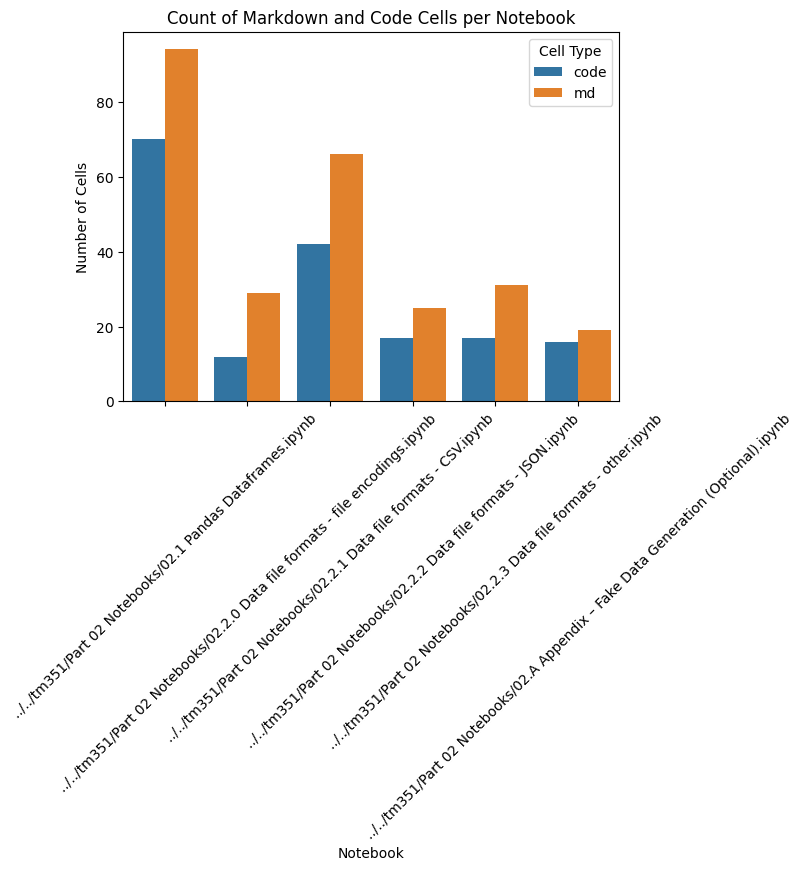

In [126]:
# Count the number of md and code cells for each notebook
count_df = ddf2.groupby(['filename', 'cell_type']).size().reset_index(name='count')

# Create the bar plot
sns.barplot(x="filename", y="count", hue="cell_type", data=count_df)

# Customize the plot
plt.title("Count of Markdown and Code Cells per Notebook")
plt.ylabel("Number of Cells")
plt.xlabel("Notebook")
plt.xticks(rotation=45)  # Rotate notebook names if needed
plt.legend(title="Cell Type")

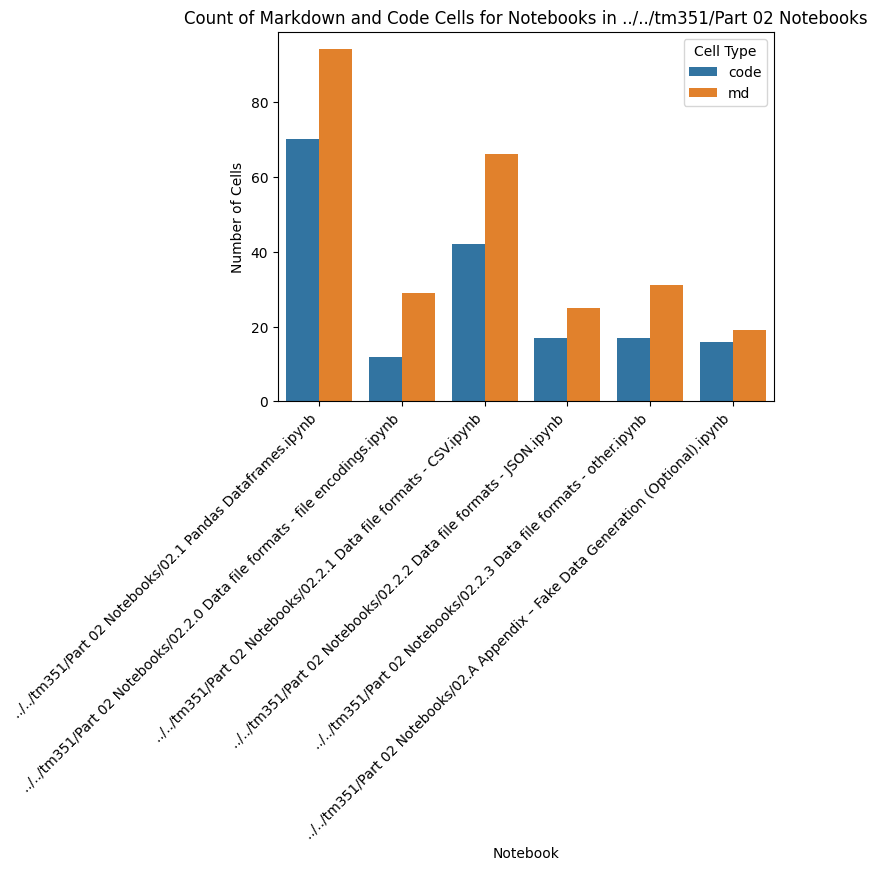

In [128]:
# Iterate over each unique path
for directory in ddf2["path"].unique():
    # Filter the DataFrame for the current directory
    directory_df = ddf2[ddf2["path"] == directory]
    
    # Count the number of md and code cells for each notebook within the directory
    count_df = directory_df.groupby(['filename', 'cell_type']).size().reset_index(name='count')
    
    # Create the bar plot
    sns.barplot(x="filename", y="count", hue="cell_type", data=count_df)
    
    # Customize the plot
    plt.title(f"Count of Markdown and Code Cells for Notebooks in {directory}")
    plt.ylabel("Number of Cells")
    plt.xlabel("Notebook")
    plt.xticks(rotation=45, ha='right')  # Rotate notebook names if needed
    plt.legend(title="Cell Type")
    
    # Show the plot
    plt.show()

## Visualising Notebook Structure

To provide a glanceable, macroscopic way of comparing the size and structure of multiple notebooks, we can generate a simple visualisation based on screen line counts and colour codes for different cell types or cell state.

Reports that include cell index and a simple line count (for example, reprting the number of code lines or screen lines for markdown) can be rendered directly as linear visualisations showing the overall structure of a notebook.

For example:

- markdown: header;
- markdown: paragraph;
- markdown: code block;
- markdown: blank line;
- code: code;
- code: comment;
- code: magic;
- code: blank line;
- other: other cells.

To profile within a cell requires access to cell internals, or generating a cell profile during cell processing.

However, it's easy enough to generate a view over the code and markdown cells.

Let's start by exploring a simple representation:

In [ ]:
#%pip install matplotlib==3.7.5

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
fig, ax = plt.subplots()
ax.axis('off')

#Simple representation of lines per cell and cell colour based on cell type
n_c = [(1, 'r'), (2, 'pink'), (1, 'cornflowerblue'), (2, 'pink')]

x = 0
y = 0

for height, color in n_c:
    _y = y + height
    plt.plot([x, x], [y, _y], color=color, linewidth=5)
    y = _y  # may want to add a gap when moving from one cell to next

plt.gca().invert_yaxis()
plt.show()

We can get the list of cell size and colour tuples from a notebook's report data frame:

In [ ]:
VIS_COLOUR_MAP  = {'md':'cornflowerblue','code':'pink'}

def cell_attrib(cell, colour='cell_type', size='n_screen_lines'):
    _colour = VIS_COLOUR_MAP[ cell[colour] ]
    return (cell[size], _colour)

In [ ]:
report.apply(cell_attrib, axis=1).to_list()

Let's create a function to visualise a notebook based on its list of cell size and colour tuples; we'll also allow it to habdle multiple lists:

In [ ]:
def nb_vis(cell_map, w=20, gap_boost=1, **kwargs):
    """Visualise notebook gross cell structure."""
    
    def get_gap(cell_map):
        """Automatically set the gap value based on overall length"""
        
        def get_overall_length(cell_map):
            """Get overall length of a notebook."""
            overall_len = 0
            gap = 0
            for i ,(l,t) in enumerate(cell_map):
                #i is number of cells if that's useful too?
                overall_len = overall_len + l
            return overall_len

        max_overall_len = 0
        
        if isinstance(cell_map,dict):
            for k in cell_map:
                _overall_len = get_overall_length(cell_map[k])
                max_overall_len = _overall_len if _overall_len > max_overall_len else max_overall_len
        else:
            max_overall_len = get_overall_length(cell_map)

        #Set the gap at 0.5% of the overall length
        return math.ceil(max_overall_len * 0.01)
        
        
    def plotter(cell_map, x, y, label='', header_gap = 0.2,
                linewidth = 5,
                orientation ='v', gap_colour = 'lightgrey'):
        """Plot visualisation of gross cell structure for a single notebook."""
        
        if orientation =='v':
            plt.text(x, y, label)
            y = y + header_gap
        else:
            plt.text(y, x, label)
            x = x + header_gap
            
        for _cell_map in cell_map:
            _y = y + gap if gap_colour else y
            __y = _y + _cell_map[0] + 1 #Make tiny cells slightly bigger
            
            if orientation =='v':
                X = _X = __X = x
                Y = y
                _Y =_y
                __Y = __y
            else:
                X = y
                _X = _y
                __X = __y
                Y = _Y = __Y = x
            
            #Add a coloured bar between cells
            if y > 0:
                if gap_colour:
                    plt.plot([X,_X],[Y,_Y], gap_colour, linewidth=linewidth)

            
            plt.plot([_X,__X], [_Y,__Y], _cell_map[1], linewidth=linewidth)

            y = __y

    x=0
    y=0
    
    if isinstance(cell_map,list):
        gap = get_gap(cell_map) * gap_boost
        fig, ax = plt.subplots(figsize=(w, 1))
        plotter(cell_map, x, y, **kwargs)
    elif isinstance(cell_map,dict):
        gap = get_gap(cell_map) * gap_boost
        fig, ax = plt.subplots(figsize=(w,len(cell_map)))
        for k in cell_map:
            plotter(cell_map[k], x, y, k, **kwargs)
            x = x + 1

    ax.axis('off')
    plt.gca().invert_yaxis()

We can now easily create a simple visualisation of the gross cell structure of the notebook:

In [ ]:
cell_mapping = report.apply(cell_attrib, axis=1).to_list()
nb_vis(cell_mapping, orientation='h')

We can alo visualisation multiple notebooks, labelling each with the notebook name and plotted against the same length axis so that we can compare notebook sizes and structures directly.

In [ ]:
nb_vis({'a':cell_mapping, 'b':cell_mapping[:3],
       'c':cell_mapping+cell_mapping, 'd':cell_mapping,}, orientation='h')

In [ ]:
def cell_attribs(cells, colour='cell_type', size='n_screen_lines'):
    return cells.apply(cell_attrib, axis=1, args=(colour,size)).to_list()

In [ ]:
zz = ddf.groupby(['filename'])[['cell_type', 'n_screen_lines']].apply(cell_attribs)
nb_vis(zz.to_dict(), orientation='h', gap_boost=1)
#[['n_total_code_lines','n_words','reading_time_mins', 'reading_time_s' ]].sum()

We can also see how they look based on reading time.

In [ ]:
zz = ddf.groupby(['filename'])[['cell_type', 'reading_time_s']].apply(cell_attribs,'cell_type','reading_time_s')
nb_vis(zz.to_dict(), orientation='h', gap_boost=2)

### Visualing Intra-Cell Structure

For example, paragraphs and code blocks in markdown cells; comment lines, empty lines, code lines, magic lines / blocks, shell command lines in code cells.

Supporting the level of detail may be be tricky. A multi-column format is probably best showing eg an approximate "screen's worth" of content in a column then the next "scroll" down displayed in the next column along.

---

# BELOW HERE - NOTES AND TO DO

In [ ]:
#Maintainability index
from radon.metrics import mi_visit

#If True, then count multiline strings as comment lines as well.
#This is not always safe because Python multiline strings are not always docstrings.

multi = True
mi_visit(c,multi)

In [ ]:
from radon.metrics import mi_parameters
mi_parameters(c, multi)

"""
the Halstead Volume
the Cyclomatic Complexity
the number of LLOC (Logical Lines of Code)
the percent of lines of comment
"""

In [ ]:
from radon.complexity import cc_visit

#Doesn't like %% or % magic
cc_visit(c)

In [ ]:
from radon.metrics import h_visit
h_visit(c)

## Checking Notebook Metrics Evolution Over Time

The `wily` package uses `radon` to produce code quality reports across a git repository history and generate charts showin the evolution of metrics over the lifetime of a repository. This suggests various corollaries:

- could we generate `wily` style measures over the recent history of a notebook code cell?
- could we generate `wily` style temporal measures over all the reports (markdown text, as well as code) generated from a notebook across several commits of it to a git repository.

## Other Cell Analysis

As a placeholder, should we also at least report on a count of cells that are note code or markdown cells?

Also a count of empty cells?

Is this moving towards some sort of notebook linter?